# **Importing Libraries and Loading the Dataset**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix, silhouette_score

import warnings
warnings.filterwarnings("ignore")

In [ ]:
school_df = pd.read_csv('/content/drive/MyDrive/School_Info.csv')
student_df = pd.read_csv('/content/drive/MyDrive/Student_Records.csv')
teacher_df = pd.read_csv('/content/drive/MyDrive/Teacher_Deployment.csv')
district_df = pd.read_csv('/content/drive/MyDrive/District_Level_Stats.csv')

In [ ]:
print("Student Records Info:")
print(student_df.info())
print(student_df.head())

Student Records Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Student_ID            50000 non-null  object 
 1   School_ID             50000 non-null  object 
 2   Grade                 50000 non-null  int64  
 3   Gender                50000 non-null  object 
 4   Socioeconomic_Status  50000 non-null  object 
 5   Attendance_Rate       47488 non-null  float64
 6   Previous_Year_GPA     50000 non-null  float64
 7   Dropout_Status        50000 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 3.1+ MB
None
  Student_ID School_ID  Grade Gender Socioeconomic_Status  Attendance_Rate  \
0   STU00001    SCH443      6      M                  Low        82.409420   
1   STU00002    SCH018      3      F                 High        68.811459   
2   STU00003    SCH193      2      F                 High  

# **Basic Data Cleaning**

In [ ]:
#Cleaning and corrections in student data
student_df.replace('', np.nan, inplace=True)
student_df['Attendance_Rate'] = pd.to_numeric(student_df['Attendance_Rate'], errors='coerce')
student_df['Previous_Year_GPA'] = pd.to_numeric(student_df['Previous_Year_GPA'], errors='coerce')

In [ ]:
# Imputing missing values
student_df['Attendance_Rate'].fillna(student_df['Attendance_Rate'].median(), inplace=True)
student_df['Previous_Year_GPA'].fillna(student_df['Previous_Year_GPA'].median(), inplace=True)

for col in ['Gender', 'Socioeconomic_Status', 'Dropout_Status']:
    student_df[col].fillna(student_df[col].mode()[0], inplace=True)

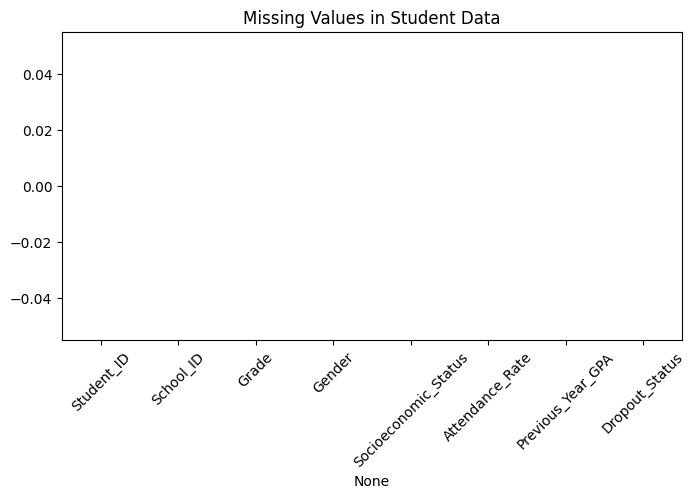

In [ ]:
# Visualizing missing values
plt.figure(figsize=(8,4))
sns.barplot(x=student_df.isnull().sum().index, y=student_df.isnull().sum().values)
plt.title('Missing Values in Student Data')
plt.xticks(rotation=45)
plt.show()

**No Missing Values Detected so it is safe to proceed**

# **Outlier Capping Using InterQuartile Range**

Capped outliers in Attendance_Rate: Lower=44.58, Upper=109.24
Capped outliers in Previous_Year_GPA: Lower=0.62, Upper=4.38


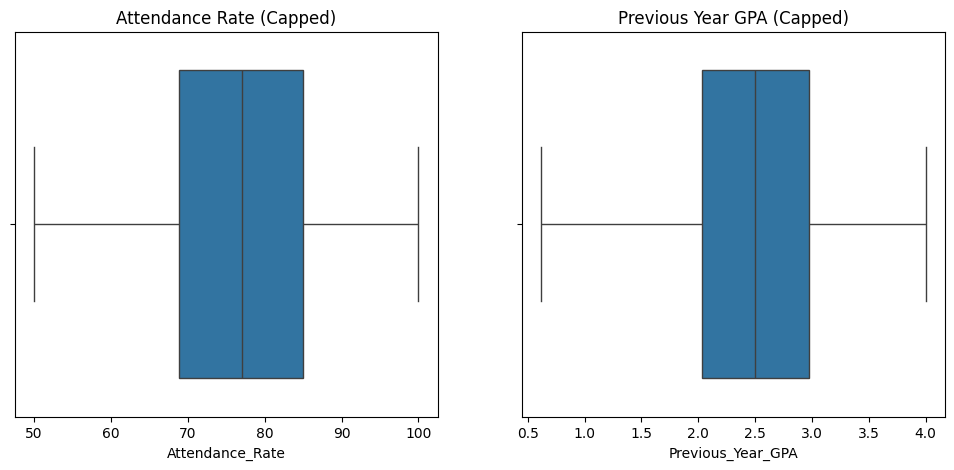

In [ ]:
def cap_outliers(df, col):
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5*iqr
    upper = q3 + 1.5*iqr
    df[col] = np.clip(df[col], lower, upper)
    print(f"Capped outliers in {col}: Lower={lower:.2f}, Upper={upper:.2f}")

cap_outliers(student_df, 'Attendance_Rate')
cap_outliers(student_df, 'Previous_Year_GPA')

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.boxplot(x=student_df['Attendance_Rate'])
plt.title('Attendance Rate (Capped)')
plt.subplot(1,2,2)
sns.boxplot(x=student_df['Previous_Year_GPA'])
plt.title('Previous Year GPA (Capped)')
plt.show()

# **Merging Teacher Dataset with School and District level stats for insights which will be shown through Visualizations**

In [ ]:
teacher_with_district = pd.merge(teacher_df, school_df[['School_ID', 'District']], on='School_ID', how='left')

merged_df = pd.merge(teacher_with_district, district_df, on='District', how='left')

# **Average Teacher Experience by District**

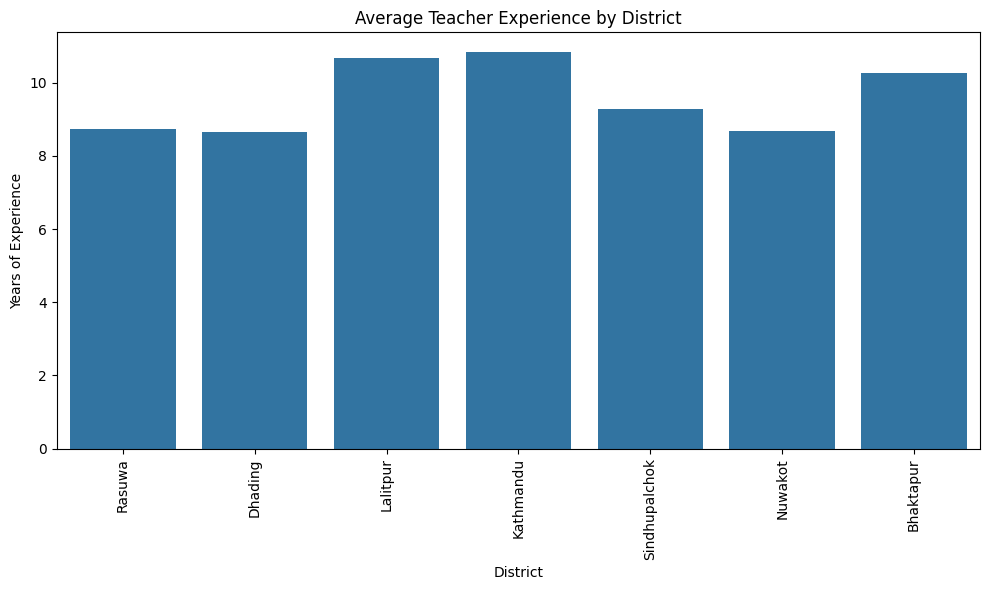

In [ ]:
plt.figure(figsize=(10,6))
sns.barplot(data=merged_df, x='District', y='Years_of_Experience', estimator='mean', ci=None)
plt.xticks(rotation=90)
plt.title("Average Teacher Experience by District")
plt.ylabel("Years of Experience")
plt.tight_layout()
plt.show()

# **Literacy Rate vs Poverty Rate by District**

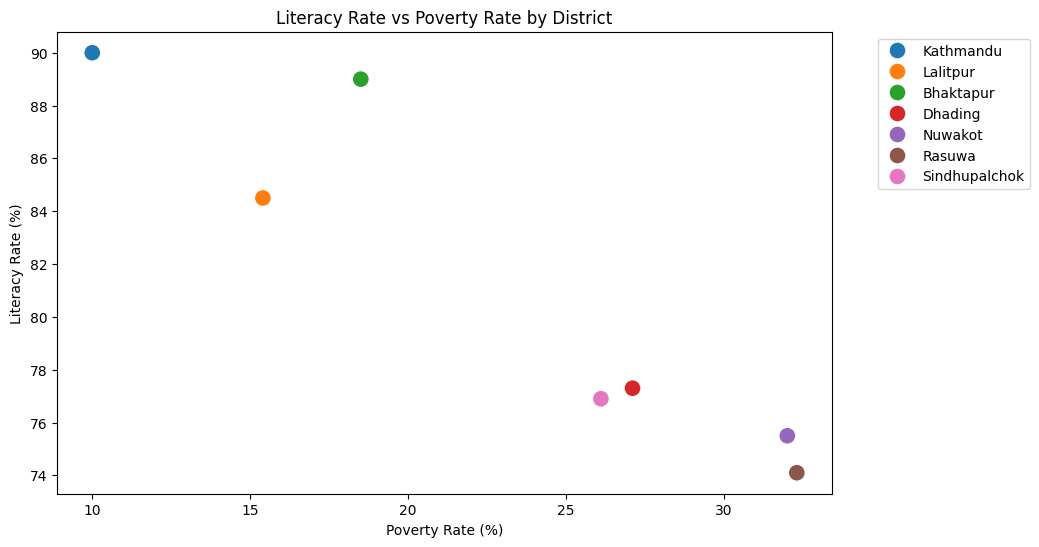

In [ ]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=district_df, x='Poverty_Rate', y='Literacy_Rate', hue='District', palette='tab10', s=150)
plt.title('Literacy Rate vs Poverty Rate by District')
plt.xlabel('Poverty Rate (%)')
plt.ylabel('Literacy Rate (%)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# **Average School Distance by District**

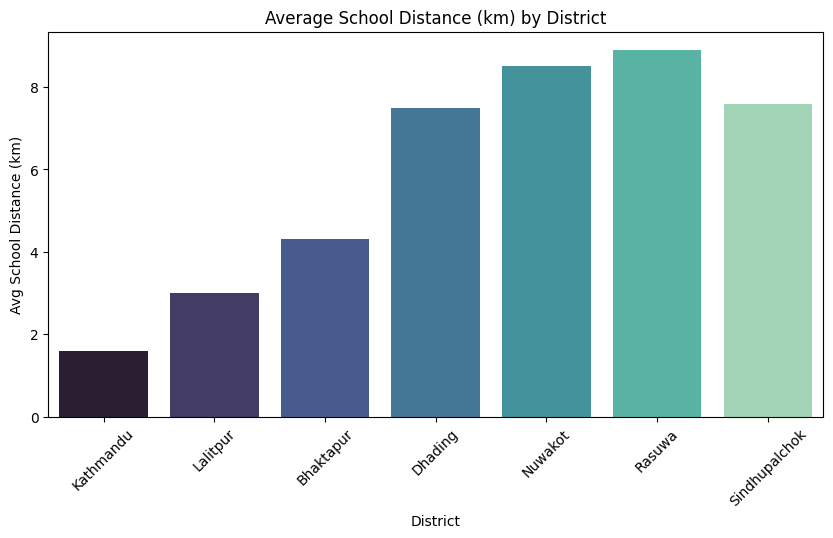

In [ ]:
plt.figure(figsize=(10,5))
sns.barplot(data=district_df, x='District', y='Avg_School_Distance_km', palette='mako')
plt.title('Average School Distance (km) by District')
plt.ylabel('Avg School Distance (km)')
plt.xlabel('District')
plt.xticks(rotation=45)
plt.show()

# **Merging School and Student's Datasets**

In [ ]:
student_df = student_df.merge(
    school_df[['School_ID', 'District', 'Location_Type']],
    on='School_ID', how='left'
)

print("\nSample merged student data:")
print(student_df.head())


Sample merged student data:
  Student_ID School_ID  Grade Gender Socioeconomic_Status  Attendance_Rate  \
0   STU00001    SCH443      6      M                  Low        82.409420   
1   STU00002    SCH018      3      F                 High        68.811459   
2   STU00003    SCH193      2      F                 High        74.794859   
3   STU00004    SCH315     11      M               Medium        80.260849   
4   STU00005    SCH223      2      F                  Low        75.388173   

   Previous_Year_GPA Dropout_Status   District Location_Type  
0               3.84              N  Kathmandu         Urban  
1               2.89              Y    Dhading         Rural  
2               2.16              N    Dhading         Rural  
3               1.90              N  Kathmandu         Urban  
4               1.92              N   Lalitpur         Urban  


# **Visualizing Student's Location Distribution and Dropout Distribution**

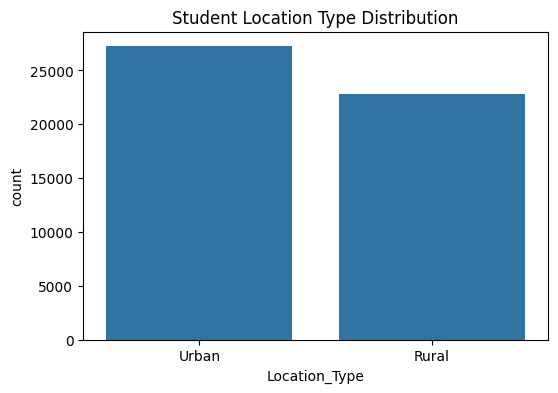

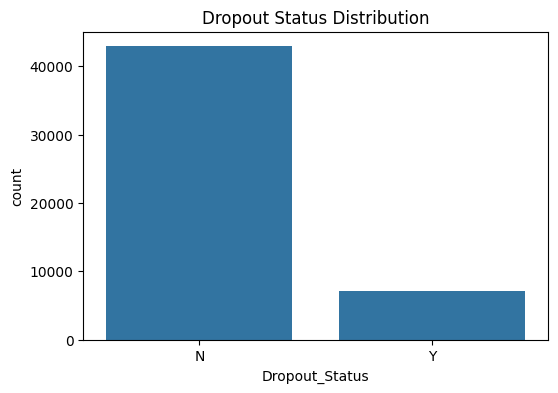

In [ ]:
plt.figure(figsize=(6,4))
sns.countplot(x='Location_Type', data=student_df)
plt.title('Student Location Type Distribution')
plt.show()

plt.figure(figsize=(6,4))
sns.countplot(x='Dropout_Status', data=student_df)
plt.title('Dropout Status Distribution')
plt.show()

# **Encoding Categorical Variables**

In [ ]:
le_dict = {}
for col in ['Gender', 'Socioeconomic_Status', 'Dropout_Status', 'District', 'Location_Type']:
    le = LabelEncoder()
    student_df[col + '_enc'] = le.fit_transform(student_df[col].astype(str))
    le_dict[col] = le
    print(f"Encoded {col} classes: {list(le.classes_)}")

Encoded Gender classes: ['F', 'M', 'Other']
Encoded Socioeconomic_Status classes: ['High', 'Low', 'Medium']
Encoded Dropout_Status classes: ['N', 'Y']
Encoded District classes: ['Bhaktapur', 'Dhading', 'Kathmandu', 'Lalitpur', 'Nuwakot', 'Rasuwa', 'Sindhupalchok']
Encoded Location_Type classes: ['Rural', 'Urban']


# **Visualizing Dropout Rate Distrubution according to the Socioeconomic Status and Attendence Rates**

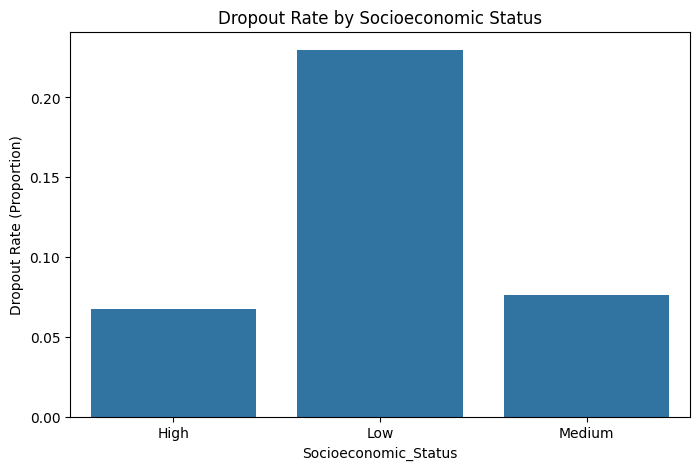

In [ ]:
dropout_by_ses = student_df.groupby('Socioeconomic_Status')['Dropout_Status_enc'].mean().reset_index()
dropout_by_ses['Dropout_Rate'] = dropout_by_ses['Dropout_Status_enc']  # encoded 'Y' as 1

plt.figure(figsize=(8,5))
sns.barplot(x='Socioeconomic_Status', y='Dropout_Rate', data=dropout_by_ses)
plt.title('Dropout Rate by Socioeconomic Status')
plt.ylabel('Dropout Rate (Proportion)')
plt.show()

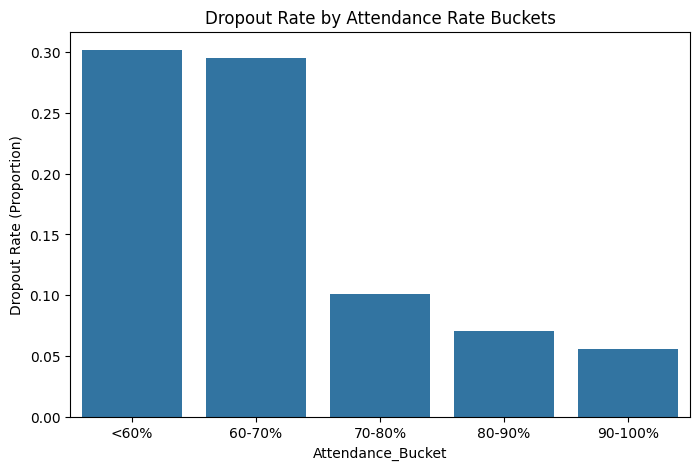

In [ ]:
student_df['Attendance_Bucket'] = pd.cut(student_df['Attendance_Rate'], bins=[0, 60, 70, 80, 90, 100], labels=['<60%', '60-70%', '70-80%', '80-90%', '90-100%'])

dropout_by_attendance = student_df.groupby('Attendance_Bucket')['Dropout_Status_enc'].mean().reset_index()
dropout_by_attendance.rename(columns={'Dropout_Status_enc': 'Dropout_Rate'}, inplace=True)

plt.figure(figsize=(8,5))
sns.barplot(x='Attendance_Bucket', y='Dropout_Rate', data=dropout_by_attendance)
plt.title('Dropout Rate by Attendance Rate Buckets')
plt.ylabel('Dropout Rate (Proportion)')
plt.show()

# **Dropout Rate by Genders**

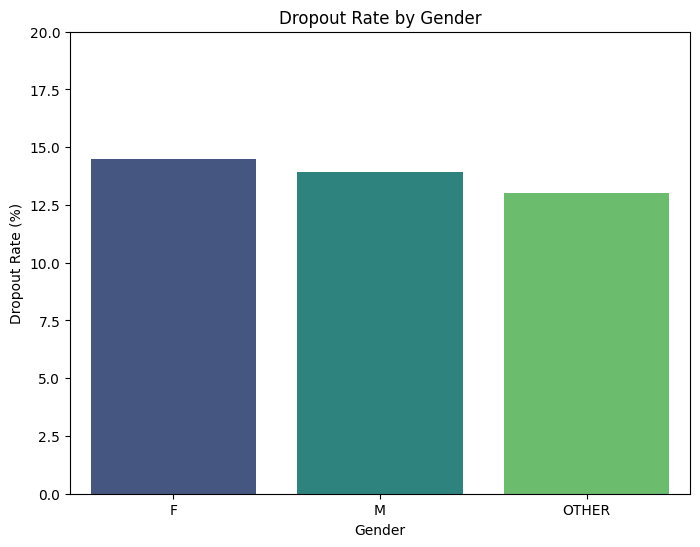

In [ ]:
student_df['Gender'] = student_df['Gender'].str.strip().str.upper()
student_df['Dropout_Status'] = student_df['Dropout_Status'].str.strip().str.upper()
student_df['Dropout_Status_enc'] = student_df['Dropout_Status'].map({'Y': 1, 'N': 0})
dropout_rate = student_df.groupby('Gender')['Dropout_Status_enc'].mean().sort_values(ascending=False) * 100

plt.figure(figsize=(8,6))
sns.barplot(x=dropout_rate.index, y=dropout_rate.values, palette='viridis')
plt.ylabel('Dropout Rate (%)')
plt.title('Dropout Rate by Gender')
plt.ylim(0, 20)
plt.show()

# **Visualizing Teacher's Training Level Distribution according to the Location Type to provide major insights on the capabilities of teachers in different areas**

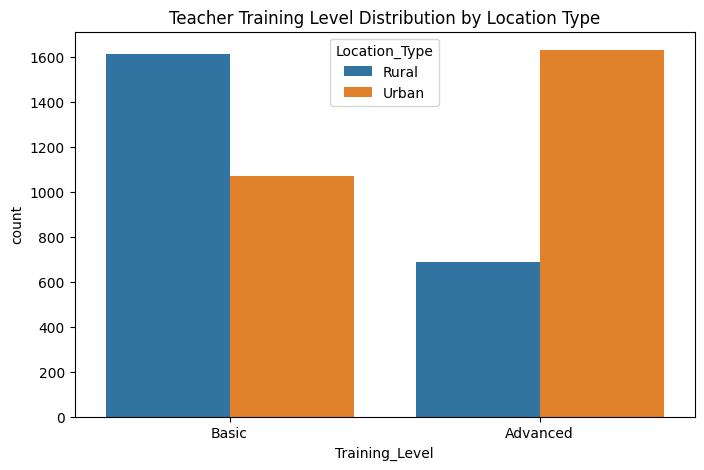

In [ ]:
teacher_df = teacher_df.merge(school_df[['School_ID', 'Location_Type']], on='School_ID', how='left')

plt.figure(figsize=(8,5))
sns.countplot(x='Training_Level', hue='Location_Type', data=teacher_df)
plt.title('Teacher Training Level Distribution by Location Type')
plt.show()

# **Correlation Heatmap**

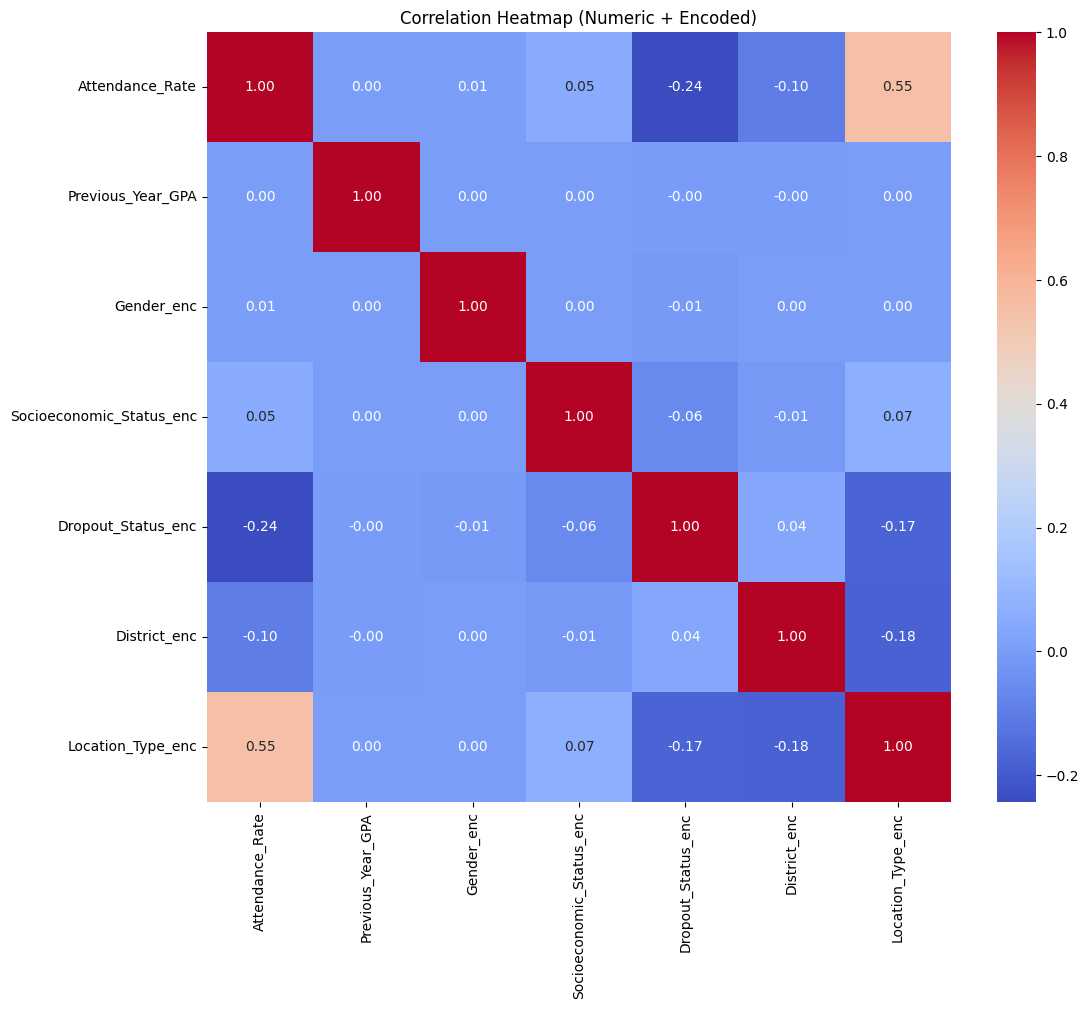

In [ ]:
numeric_cols = ['Attendance_Rate', 'Previous_Year_GPA'] + [col+'_enc' for col in ['Gender', 'Socioeconomic_Status', 'Dropout_Status', 'District', 'Location_Type']]
plt.figure(figsize=(12,10))
sns.heatmap(student_df[numeric_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap (Numeric + Encoded)')
plt.show()

# **Top Reasons for Dropout**

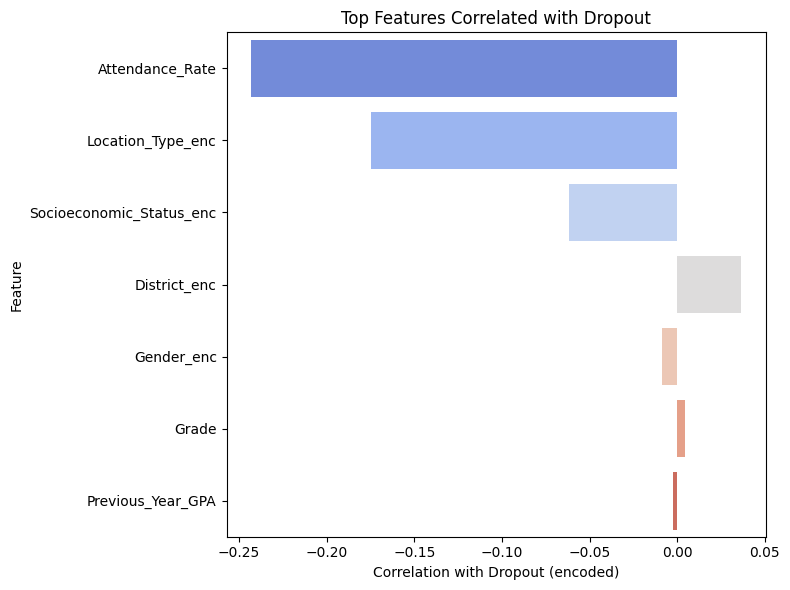

In [ ]:
corr_matrix = student_df.corr(numeric_only=True)

dropout_corr = corr_matrix['Dropout_Status_enc'].drop('Dropout_Status_enc').sort_values(key=abs, ascending=False)
top_corr = dropout_corr.head(10)
plt.figure(figsize=(8,6))
sns.barplot(x=top_corr.values, y=top_corr.index, palette='coolwarm')
plt.title('Top Features Correlated with Dropout')
plt.xlabel('Correlation with Dropout (encoded)')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# **Preparing data for Logistic Regression and Scaling Numeric Features**

In [ ]:
features = ['Attendance_Rate', 'Previous_Year_GPA', 'Gender_enc', 'Socioeconomic_Status_enc', 'District_enc', 'Location_Type_enc']
X = student_df[features]
y = student_df['Dropout_Status_enc']

In [ ]:
scaler = StandardScaler()
X[['Attendance_Rate', 'Previous_Year_GPA']] = scaler.fit_transform(X[['Attendance_Rate', 'Previous_Year_GPA']])

In [ ]:
print("Class distribution before SMOTE:")
print(y.value_counts(normalize=True))

Class distribution before SMOTE:
Dropout_Status_enc
0    0.8581
1    0.1419
Name: proportion, dtype: float64


# **Applying SMOTE to balance the classes**

In [ ]:
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)
print("Class distribution after SMOTE:")
print(pd.Series(y_res).value_counts(normalize=True))

Class distribution after SMOTE:
Dropout_Status_enc
0    0.5
1    0.5
Name: proportion, dtype: float64


# **Logistic Regression with class weight balanced and Stratified K Fold Cross Validation**

In [ ]:
logreg = LogisticRegression(max_iter=500, random_state=42, class_weight='balanced')
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

y_pred_cv = cross_val_predict(logreg, X_res, y_res, cv=skf)
print(classification_report(y_res, y_pred_cv, target_names=le_dict['Dropout_Status'].classes_))

for fold, (train_idx, test_idx) in enumerate(skf.split(X_res, y_res)):
    X_train, X_test = X_res.iloc[train_idx], X_res.iloc[test_idx]
    y_train, y_test = y_res.iloc[train_idx], y_res.iloc[test_idx]

    logreg.fit(X_train, y_train)
    y_pred = logreg.predict(X_test)

    print(f"\nFold {fold + 1} Classification Report:")
    print(classification_report(y_test, y_pred, target_names=le_dict['Dropout_Status'].classes_))

              precision    recall  f1-score   support

           N       0.68      0.65      0.66     42905
           Y       0.66      0.69      0.68     42905

    accuracy                           0.67     85810
   macro avg       0.67      0.67      0.67     85810
weighted avg       0.67      0.67      0.67     85810


Fold 1 Classification Report:
              precision    recall  f1-score   support

           N       0.67      0.64      0.66      8581
           Y       0.66      0.69      0.67      8581

    accuracy                           0.67     17162
   macro avg       0.67      0.67      0.67     17162
weighted avg       0.67      0.67      0.67     17162


Fold 2 Classification Report:
              precision    recall  f1-score   support

           N       0.68      0.66      0.67      8581
           Y       0.67      0.69      0.68      8581

    accuracy                           0.67     17162
   macro avg       0.67      0.67      0.67     17162
weighted avg

# **Confusion Matrix**

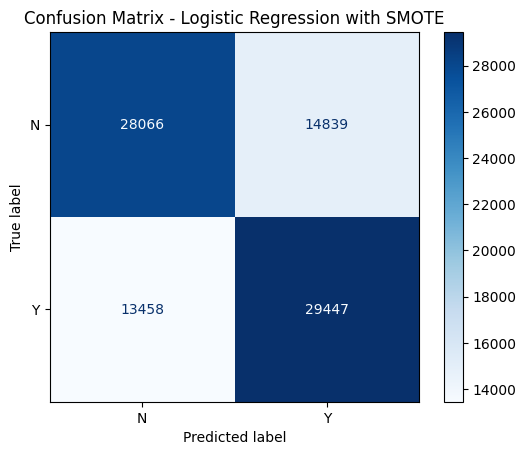

In [ ]:
cm = confusion_matrix(y_res, y_pred_cv)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le_dict['Dropout_Status'].classes_)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix - Logistic Regression with SMOTE')
plt.show()

# **ROC Curve and AUC**

In [ ]:
logreg.fit(X_res, y_res)
y_probs = logreg.predict_proba(X_res)[:, 1]
fpr, tpr, _ = roc_curve(y_res, y_probs)
auc_score = roc_auc_score(y_res, y_probs)

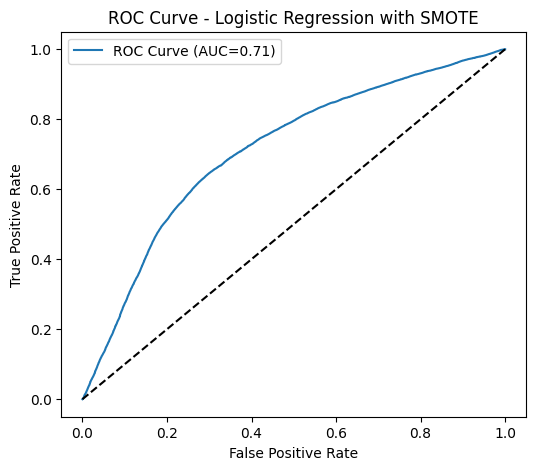

In [ ]:
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC={auc_score:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression with SMOTE')
plt.legend()
plt.show()

# **Performing K-Means Clustering on School data for Segmentation**

In [ ]:
# Encoding categorical school data with fillna
for col in ['Location_Type', 'Electricity_Access', 'Internet_Access', 'Library_Status']:
    school_df[col] = school_df[col].fillna('Unknown').astype(str)
    le = LabelEncoder()
    school_df[col + '_enc'] = le.fit_transform(school_df[col])
    print(f"Encoded {col} in school_df")

cluster_features = ['Infrastructure_Score', 'Electricity_Access_enc', 'Internet_Access_enc', 'Library_Status_enc', 'Location_Type_enc']
X_cluster = school_df[cluster_features]

scaler_cluster = StandardScaler()
X_cluster_scaled = scaler_cluster.fit_transform(X_cluster)

Encoded Location_Type in school_df
Encoded Electricity_Access in school_df
Encoded Internet_Access in school_df
Encoded Library_Status in school_df


# **Using the Elbow Method to find Optimal K**

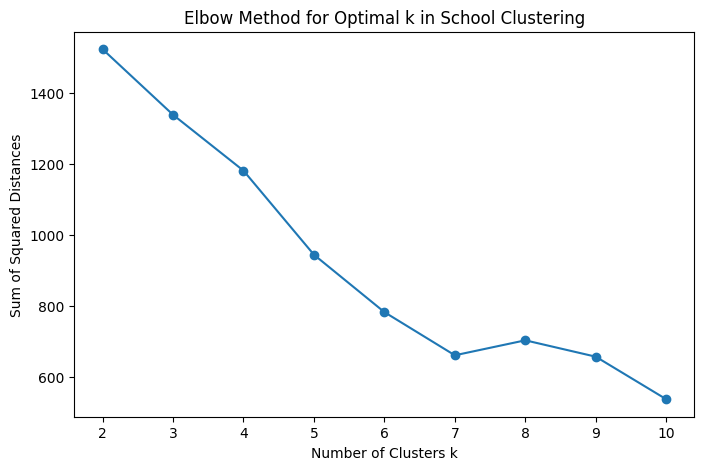

In [ ]:
sse = []
for k in range(2, 11):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_cluster_scaled)
    sse.append(km.inertia_)

plt.figure(figsize=(8,5))
plt.plot(range(2, 11), sse, marker='o')
plt.title('Elbow Method for Optimal k in School Clustering')
plt.xlabel('Number of Clusters k')
plt.ylabel('Sum of Squared Distances')
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=4, random_state=42)
school_df['Cluster'] = kmeans.fit_predict(X_cluster_scaled)

# Silhouette Score
sil_score = silhouette_score(X_cluster_scaled, school_df['Cluster'])
print(f"Silhouette Score for k=4: {sil_score:.3f}")

Silhouette Score for k=4: 0.340


# **PCA-Based Visualization of School Clustering Results**

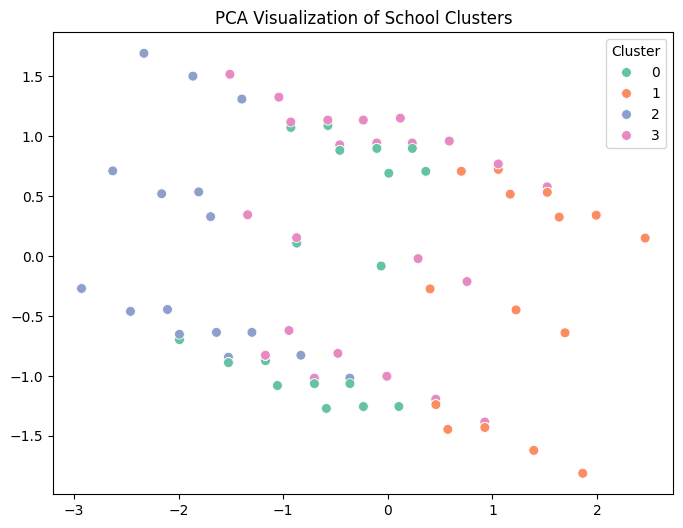

In [ ]:
pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_cluster_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(x=pca_components[:,0], y=pca_components[:,1], hue=school_df['Cluster'], palette='Set2', s=50)
plt.title('PCA Visualization of School Clusters')
plt.show()

In [ ]:
# Cluster summary
print("Cluster-wise average feature values:")
print(school_df.groupby('Cluster')[cluster_features].mean())

Cluster-wise average feature values:
         Infrastructure_Score  Electricity_Access_enc  Internet_Access_enc  \
Cluster                                                                      
0                    2.093750                0.500000                  1.0   
1                    3.407407                0.939815                  1.0   
2                    1.863248                0.393162                  0.0   
3                    2.815534                0.941748                  0.0   

         Library_Status_enc  Location_Type_enc  
Cluster                                         
0                  0.843750           0.078125  
1                  1.361111           1.000000  
2                  0.410256           0.025641  
3                  1.466019           0.475728  
